In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tqdm import tqdm
import simpleaudio as sa
from sklearn.model_selection import train_test_split

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [32]:
import os
from os.path import join as pjoin
import simpleaudio as sa
from scipy.io import wavfile


original_data_dir = pjoin(os.getcwd(),"../AudioFiles","wavs")
compressed_data_dir = pjoin(os.getcwd(),"../AudioFiles","medio")
original_fname = pjoin(original_data_dir, '215_tdcast_1991.wav')
compressed_fname = pjoin(compressed_data_dir, '215_tdcast_1991.wav')

samplerate_original, original_data = wavfile.read(original_fname)
print(f"number of channels = {original_data.shape[1]}")

length = original_data.shape[0] / samplerate_original
print(f"length = {length}s")

samplerate_compressed, compressed_data = wavfile.read(compressed_fname)
fs = samplerate_compressed

<ipython-input-32-4807b5feff37>:12: WavFileWarning: Chunk (non-data) not understood, skipping it.
  samplerate_original, original_data = wavfile.read(original_fname)


number of channels = 2
length = 3895.2228571428573s


<ipython-input-32-4807b5feff37>:18: WavFileWarning: Chunk (non-data) not understood, skipping it.
  samplerate_compressed, compressed_data = wavfile.read(compressed_fname)


In [33]:
compressed_data = np.array(compressed_data[:,0].reshape(-1,1))
original_data = np.array(original_data[:,0].reshape(-1,1))

In [34]:

play_obj = sa.play_buffer(original_data[100000:200000].reshape(-1), 1, 2, fs)
#play_obj.wait_done()

In [35]:
play_obj.stop()

In [6]:
seq = original_data[:samplerate_original*5]
volume = .3
normalization = 32767 / np.max(np.abs(seq))
audio = (seq[:,0].reshape(-1)*normalization*volume).astype(np.int16)
play_obj = sa.play_buffer(audio, 1, 2, samplerate_original)

In [11]:
len(compressed_data) - len(original_data)

0

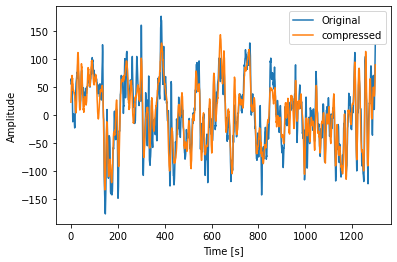

In [36]:
import matplotlib.pyplot as plt
import numpy as np
# time = np.linspace(0., 10000, data.shape[0])
plt.plot(original_data[10700:12000, 0], label="Original")
plt.plot(compressed_data[10700:12000, 0], label="compressed")
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()

In [37]:
samplesize = 100
clean_audio = original_data#[:10000000]
dirty_audio = compressed_data#[:10000000]

In [38]:
def getSamplesFromFile(file, samplesize):
    n_chunks = len(file)//samplesize
    return file[:n_chunks*samplesize].reshape(-1,samplesize,1)

def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

In [39]:
y = getSamplesFromFile(clean_audio, samplesize)
X = getSamplesFromFile(dirty_audio, samplesize)

#X_train, X_valid, Y_train, Y_valid = train_test_split(X, y, test_size=0.1, random_state=42)
val_start = int(len(X)*.9)
X_train,X_valid = X[:val_start],X[val_start:]
Y_train,Y_valid = y[:val_start],y[val_start:]

In [40]:
X_train.shape

(1546013, 100, 1)

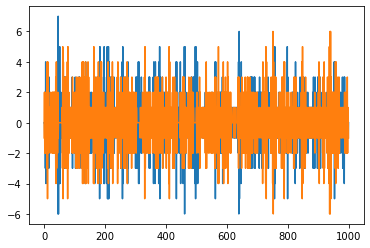

In [41]:
plt.plot(X_train[0:10].reshape(-1))
plt.plot(Y_train[0:10].reshape(-1))
plt.show()

In [72]:
input_ = keras.layers.Input(shape=X_train.shape[1:])

hidden1 = keras.layers.Conv1D(filters=64, kernel_size=6, padding='same', activation='elu')(input_)
hidden2 = keras.layers.MaxPooling1D(pool_size=2, padding='same')(hidden1)
hidden3 = keras.layers.Conv1D(filters=128, kernel_size=6, padding='same', activation='elu')(hidden2)
hidden4 = keras.layers.UpSampling1D(size=2)(hidden3)

lay = keras.layers.Dense(128)(hidden4)
lay = keras.layers.BatchNormalization()(lay)
lay = keras.layers.Dropout(0.2)(lay)
lay = keras.layers.Dense(64)(lay)
lay = keras.layers.BatchNormalization()(lay)
lay = keras.layers.Dropout(0.2)(lay)
output = keras.layers.Dense(1)(lay)

model = keras.models.Model(inputs=[input_], outputs=[output])

In [73]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 100, 1)]          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 100, 64)           448       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 50, 64)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 50, 128)           49280     
_________________________________________________________________
up_sampling1d_2 (UpSampling1 (None, 100, 128)          0         
_________________________________________________________________
dense_4 (Dense)              (None, 100, 128)          16512     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100, 128)          512 

In [74]:
optimizer = keras.optimizers.RMSprop(lr=1)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, Y_train, epochs=5, batch_size=2048,
                    validation_data=(X_valid, Y_valid))

Epoch 1/5
755/755 [==============================] - 84s 111ms/step - loss: 1702549.3750 - val_loss: 4303490.0000
Epoch 2/5
755/755 [==============================] - 83s 110ms/step - loss: 1347373.3750 - val_loss: 1423671.8750
Epoch 3/5
755/755 [==============================] - 83s 111ms/step - loss: 1337705.1250 - val_loss: 1856081.3750
Epoch 4/5
755/755 [==============================] - 83s 111ms/step - loss: 1325962.7500 - val_loss: 976657.0000
Epoch 5/5
755/755 [==============================] - 83s 111ms/step - loss: 1332337.8750 - val_loss: 1062435.1250


In [85]:
#4928491.5000
#1496164.2500
#2036409.7500 
#Colocar result de 1 densa no relatorio
#Treinar com seq inteira 
model.save('./checkpoints/dense_conv_model')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./checkpoints/dense_conv_model\assets


In [86]:
model = keras.models.load_model('./checkpoints/dense_conv_model')

In [15]:
_ = plt.plot(model.layers[4].weights[0].numpy())

IndexError: list index out of range

In [87]:
predicted = model.predict(X_valid)

In [88]:
predicted.shape

(171780, 100, 1)

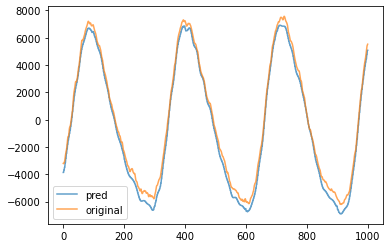

In [89]:
plt.plot(predicted[0:10].reshape(-1), label="pred", alpha=.7)
plt.plot(Y_valid[0:10].reshape(-1), label="original", alpha=.7)
plt.legend()
plt.show()

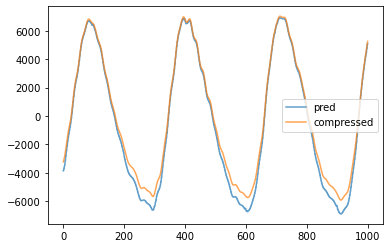

In [78]:
plt.plot(predicted[0:10].reshape(-1), label="pred", alpha=.7)
plt.plot(X_valid[0:10].reshape(-1), label="compressed", alpha=.7)
plt.legend()
plt.show()

In [78]:
predicted = model.predict(X_train)

In [79]:
X_train.shape

(180000, 50, 1)

In [46]:
def play_seq(seq, volume):
    normalization = 32767 / np.max(np.abs(seq))
    audio = (seq.reshape(-1)*normalization*volume).astype(np.int16)
    play_obj = sa.play_buffer(audio, 1, 2, samplerate_original)
    return play_obj

In [79]:
x = play_seq(X_valid, 1) #Comprimido

In [80]:
x.stop()

In [81]:
x = play_seq(predicted, 1) #Predito

In [82]:
x.stop()

In [83]:
x= play_seq(Y_valid, .8) #Oliginal

In [84]:
x.stop()

In [170]:
def save_seq(name,seq, volume, samplerate):
    normalization = 32767 / np.max(np.abs(seq))
    audio = (seq.reshape(-1)*normalization*volume).astype(np.int16)
    wavfile.write(name,samplerate*2,audio)

In [186]:
save_seq("predicted.wav", predicted, .5, samplerate)
save_seq("shouldbe.wav", Y_train, 1, samplerate)
save_seq("itwas.wav", X_train, 1, samplerate)

In [163]:
predicted.shape

(90000, 10, 1)